## Корректно ли работает система сплитования? АА-тест.

При проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между 0 и 1 группой не только в конкретно нашем АА-тесте, но и в целом.

У нас есть данные А/А-теста с '2023-10-18' по '2023-10-24'. 

Сделаем симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации  сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы, а затем проведем сравнение этих подвыборок t-testом.

### 1. Подготовка к работе

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

### 2. Загрузка данных

In [2]:
#параметры соединения 
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231113',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
#текст запроса
query = '''
select exp_group, 
user_id,
sum(action = 'view') as views,
sum(action = 'like') as likes,
likes/views as ctr
from {db}.feed_actions
where toDate(time) between '2023-10-18' and '2023-10-24'
  and exp_group in (2,3)
group by exp_group, user_id
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head()

,exp_group,user_id,views,likes,ctr
0,3,115383,248,38,0.153226
1,3,10326,132,24,0.181818
2,3,123580,122,25,0.204918
3,2,131473,98,19,0.193878
4,2,23985,44,12,0.272727


### 3. Анализ данных

Отобразим на графиках распределение ctr 2 и 3 группы

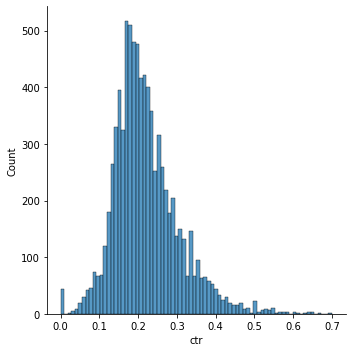

In [5]:
# Распределение экспериментальной группы 2
sns.displot(df[df.exp_group == 2].ctr, kde = False)

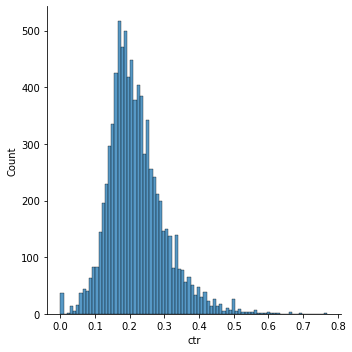

In [6]:
# Распределение экспериментальной группы 3
sns.displot(df[df.exp_group == 3].ctr, kde = False)

Xарактер распределения и медиана схожи у обеих групп. Явных визуальных различий в распределениях между экспериментальными группами нет

In [5]:
group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 3].copy()

In [6]:
# Симуляция 10000 АА-тестов на выборках по 500 пользователей из каждой группы
n_tests = 10000
n_samples = 500
p_values_list = []
for i in range(n_tests):
    group_2 = df[df['exp_group']==2].ctr.sample(n_samples, replace=True)
    group_3 = df[df['exp_group']==3].ctr.sample(n_samples, replace=True)
    # Т-тест
    p_value = stats.ttest_ind(group_2, group_3, equal_var=False)[1]
    p_values_list.append(p_value)

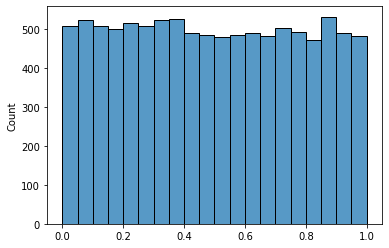

In [7]:
# построим гистограмму распределения получившихся 10000 p-values   
ax = sns.histplot(p_values_list, bins=20)

In [9]:
# посчитаем, какой процент p-values оказался меньше либо равен 0.05

sum(np.array(p_values_list)<0.05)/10000

0.0507

##### Вывод: 
Полученная гистограмма позволяет сделать вывод, что p-value распространено равномерно.
К тому же 5% p-values оказалось меньше либо равно заданному 0.05. Таким образом, система сплитования работает корректно.